In [64]:
# Import libraries needed
# !pip install geopandas
# !pip install geopy    # Done @25/4
# !conda install -c conda-forge --no-deps folium=0.10.0 --yes
import geopy
from geopy.geocoders import Nominatim
from collections import OrderedDict
import json, requests
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim
# !pip install folium   # Done @25/4
import folium 
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
# !pip install matplotlib_venn   # Done @25/4
from matplotlib_venn import venn2
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

In [2]:
# New York data to read
url = 'https://cocl.us/new_york_dataset'
ny_data = requests.get(url).json()

# relevant information is in 'features' key
ny_data = ny_data['features']
ny_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [3]:
# Store the information from the json file into a dataframe
tmp_columns = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']
ny_df = pd.DataFrame(columns = tmp_columns)
for data in ny_data:
    borough = data['properties']['borough']
    neigh   = data['properties']['name']
    lat_lon = data['geometry']['coordinates'] # now it'll return list
    lon, lat = lat_lon[0], lat_lon[1]
    
    ny_df = ny_df.append({'Borough': borough,'Neighbourhood': neigh, 'Latitude': lat,
                          'Longitude': lon}, ignore_index=True)
    
ny_df.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
# Toronto data - Scraping and Cleaning

# Wikipedia url for our Toronto neighborhoods data; an earlier version for the correct data structure
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=942851379'
# Beautifulsoup to download html data
req = requests.get(url)
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
neighborhood=pd.DataFrame(df[0])

# Drop "Not Assigned" Neighborhoods
neighborhood['Neighbourhood'].replace('Not assigned', np.nan, inplace=True)
neighborhood.dropna(subset=['Neighbourhood'], inplace=True)
neighborhood.reset_index(drop=True, inplace=True)
# Check our current data
print('Our dataframe has {} rows in total and {} with value "Not Assigned" in the Neighbourhood column'.
      format(neighborhood.shape[0], len(neighborhood[neighborhood['Neighbourhood']=='Not assigned'])))
# Check if there are "Boroughs" with "NA" values, in order to replace them with their respective Neighborhood
print('The column "Borough" has {} rows with the value "Not Assigned"'.
     format(len(neighborhood[neighborhood['Borough']=='Not assigned'])))

# Group our data by Postcode and Borough
neighborhood = neighborhood.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
# Getting the .csv file from the url provided in the lab
geo_coord_url = 'https://cocl.us/Geospatial_data'
geo_coord_data = pd.read_csv(geo_coord_url)

# A bit of manipulation for easier data merge
geo_coord_data.columns = ['Postcode', 'Latitude', 'Longitude']
# Merge of the two tables into a new one and see our result
Toronto_geodata = pd.merge(neighborhood, geo_coord_data, how = 'left', on = 'Postcode')
print("Our combined dataframe's shape is {}".format(Toronto_geodata.shape))
Toronto_geodata.head()

Our dataframe has 210 rows in total and 0 with value "Not Assigned" in the Neighbourhood column
The column "Borough" has 0 rows with the value "Not Assigned"
Our combined dataframe's shape is (103, 5)


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [21]:
# Foursquare api's credentials and initial values
CLIENT_ID = 'W5OCUDV012XVRSPW5KRTYG3Z4F3TJJOEXO34H444DPFFO4CS' # your Foursquare ID
CLIENT_SECRET = 'ISUHJGMXK4FCPSASV1DSWKT3AM4Y0YJZJZEAB143Z1Z3T2KX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

In [22]:
# get_near_by_venues function statement

def get_near_by_venues(names, latitudes, longitudes, radius= 1000):    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)    

        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighbourhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return nearby_venues

In [23]:
# explore_borough function statement

def explore_borough(df, borough):
    new_df = df[df['Borough'] == borough].reset_index(drop = True)
    venues =  get_near_by_venues(names = new_df['Neighbourhood'],latitudes = new_df['Latitude'],
                                 longitudes = new_df['Longitude'])

    onehot_df = pd.get_dummies(venues[['Venue Category']], prefix= "", prefix_sep= "")

    # # add neighborhood column back to dataframe
    onehot_df['Neighbourhood'] = venues['Neighbourhood']
    # move neighborhood column to the first column
    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]
    onehot_df_grouped = onehot_df.groupby('Neighbourhood').mean().reset_index()
    
    onehot_coded_df = pd.merge(new_df, onehot_df_grouped, on = 'Neighbourhood', how = 'left')
    
    return onehot_coded_df

In [24]:
# Venues4Boroughs function statement - The Final Piece

def return_venues_for_boroughs(df):
    col = list(df.columns)
    all_venues = pd.DataFrame()
    for i in df['Borough'].unique():
        new_df = df[df['Borough'] == i]
        print('For borough: ',i)
        a = explore_borough(new_df, i)
        all_venues = pd.concat([a, all_venues], axis = 0, ignore_index = True, sort = True)
    cols = col + [j for j in all_venues.columns if j not in col]
    all_venues = all_venues[cols]
    return all_venues

In [25]:
# Dataset for New York

df1 = return_venues_for_boroughs(ny_df)
df1.fillna(0,  inplace = True)
print('Data Shape is: ', df1.shape)
df1.head()

For borough:  Bronx
For borough:  Manhattan
For borough:  Brooklyn
For borough:  Queens
For borough:  Staten Island
Data Shape is:  (306, 484)


,Borough,Neighbourhood,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini

In [26]:
# Exported to dataframe for future use
# df1.to_csv('NewYorkData.csv', index = False)

In [27]:
# Now for Toronto

df2 = return_venues_for_boroughs(Toronto_geodata)
df2.fillna(0, inplace = True)
print('Data Shape is: ', df2.shape)
df2.head()

For borough:  Scarborough
For borough:  North York
For borough:  East York
For borough:  East Toronto
For borough:  Central Toronto
For borough:  Downtown Toronto
For borough:  York
For borough:  West Toronto
For borough:  Mississauga
For borough:  Etobicoke
Data Shape is:  (103, 329)


,Postcode,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Lab,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speake

In [28]:
# Exported to dataframe for future use
# df2.to_csv('TorontoData.csv', index = False)

In [37]:
# Making deep copies of our dataframes, will be used later on
ny_df = df1.copy()
to_df = df2.copy().drop('Postcode', 1)

In [38]:
# After extensive trial & fail, we found out that there were inconsistencies in the NYC data. In more detail, there
# were Neighbourhoods that have the same Name but are in different Boroughs. In order to fix this, we'll add 
# the Borough suffix for those Neighbourhoods.

for i in range(ny_df.shape[0]):
    nyn_ = ny_df.loc[i, 'Neighbourhood']
    if ny_df[ny_df['Neighbourhood'] == nyn_].shape[0] > 1:
        ind_ = ny_df[ny_df['Neighbourhood'] == nyn_].index.tolist()
        for j in ind_:
            nyb__ = ny_df.loc[j, 'Borough']
            ny_df.loc[j, 'Neighbourhood'] = nyn_ + ', ' + nyb__

# The code cells that follow is a test case, using Cosine similarity to find out the Nth most similar Neighbourhoods between a Neighbourhood in the other city.
## This may not be the optimal way to go, and this is why we are using this as a test case, to compare between this method and our final one, using K Means Clustering
#### This part may be easily skipped, as it was mainly used because I had the code below ready from another project and thought it worthwhile to take a look at this

In [174]:
# Find the most common venues between the two cities
print('Leaving {} columns of New York city data\nLeaving {} columns of Toronto city data'
      .format(list(df1.columns[0:4]), list(df2.columns[0:5])))
common = 0
diff_in_NY = 0

for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        common += 1
    else:
        diff_in_NY += 1

print('\nNumber of common venue categories in both data are       : {}\n\
Number of different venue categories in New York city are: {}\n\
Number of different venue catehories in Toronto city are : {}'.format(common, diff_in_NY,
                                                                     len(df2.columns[5:])-common))

Leaving ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] columns of New York city data
Leaving ['Postcode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude'] columns of Toronto city data

Number of common venue categories in both data are       : 290
Number of different venue categories in New York city are: 190
Number of different venue catehories in Toronto city are : 34


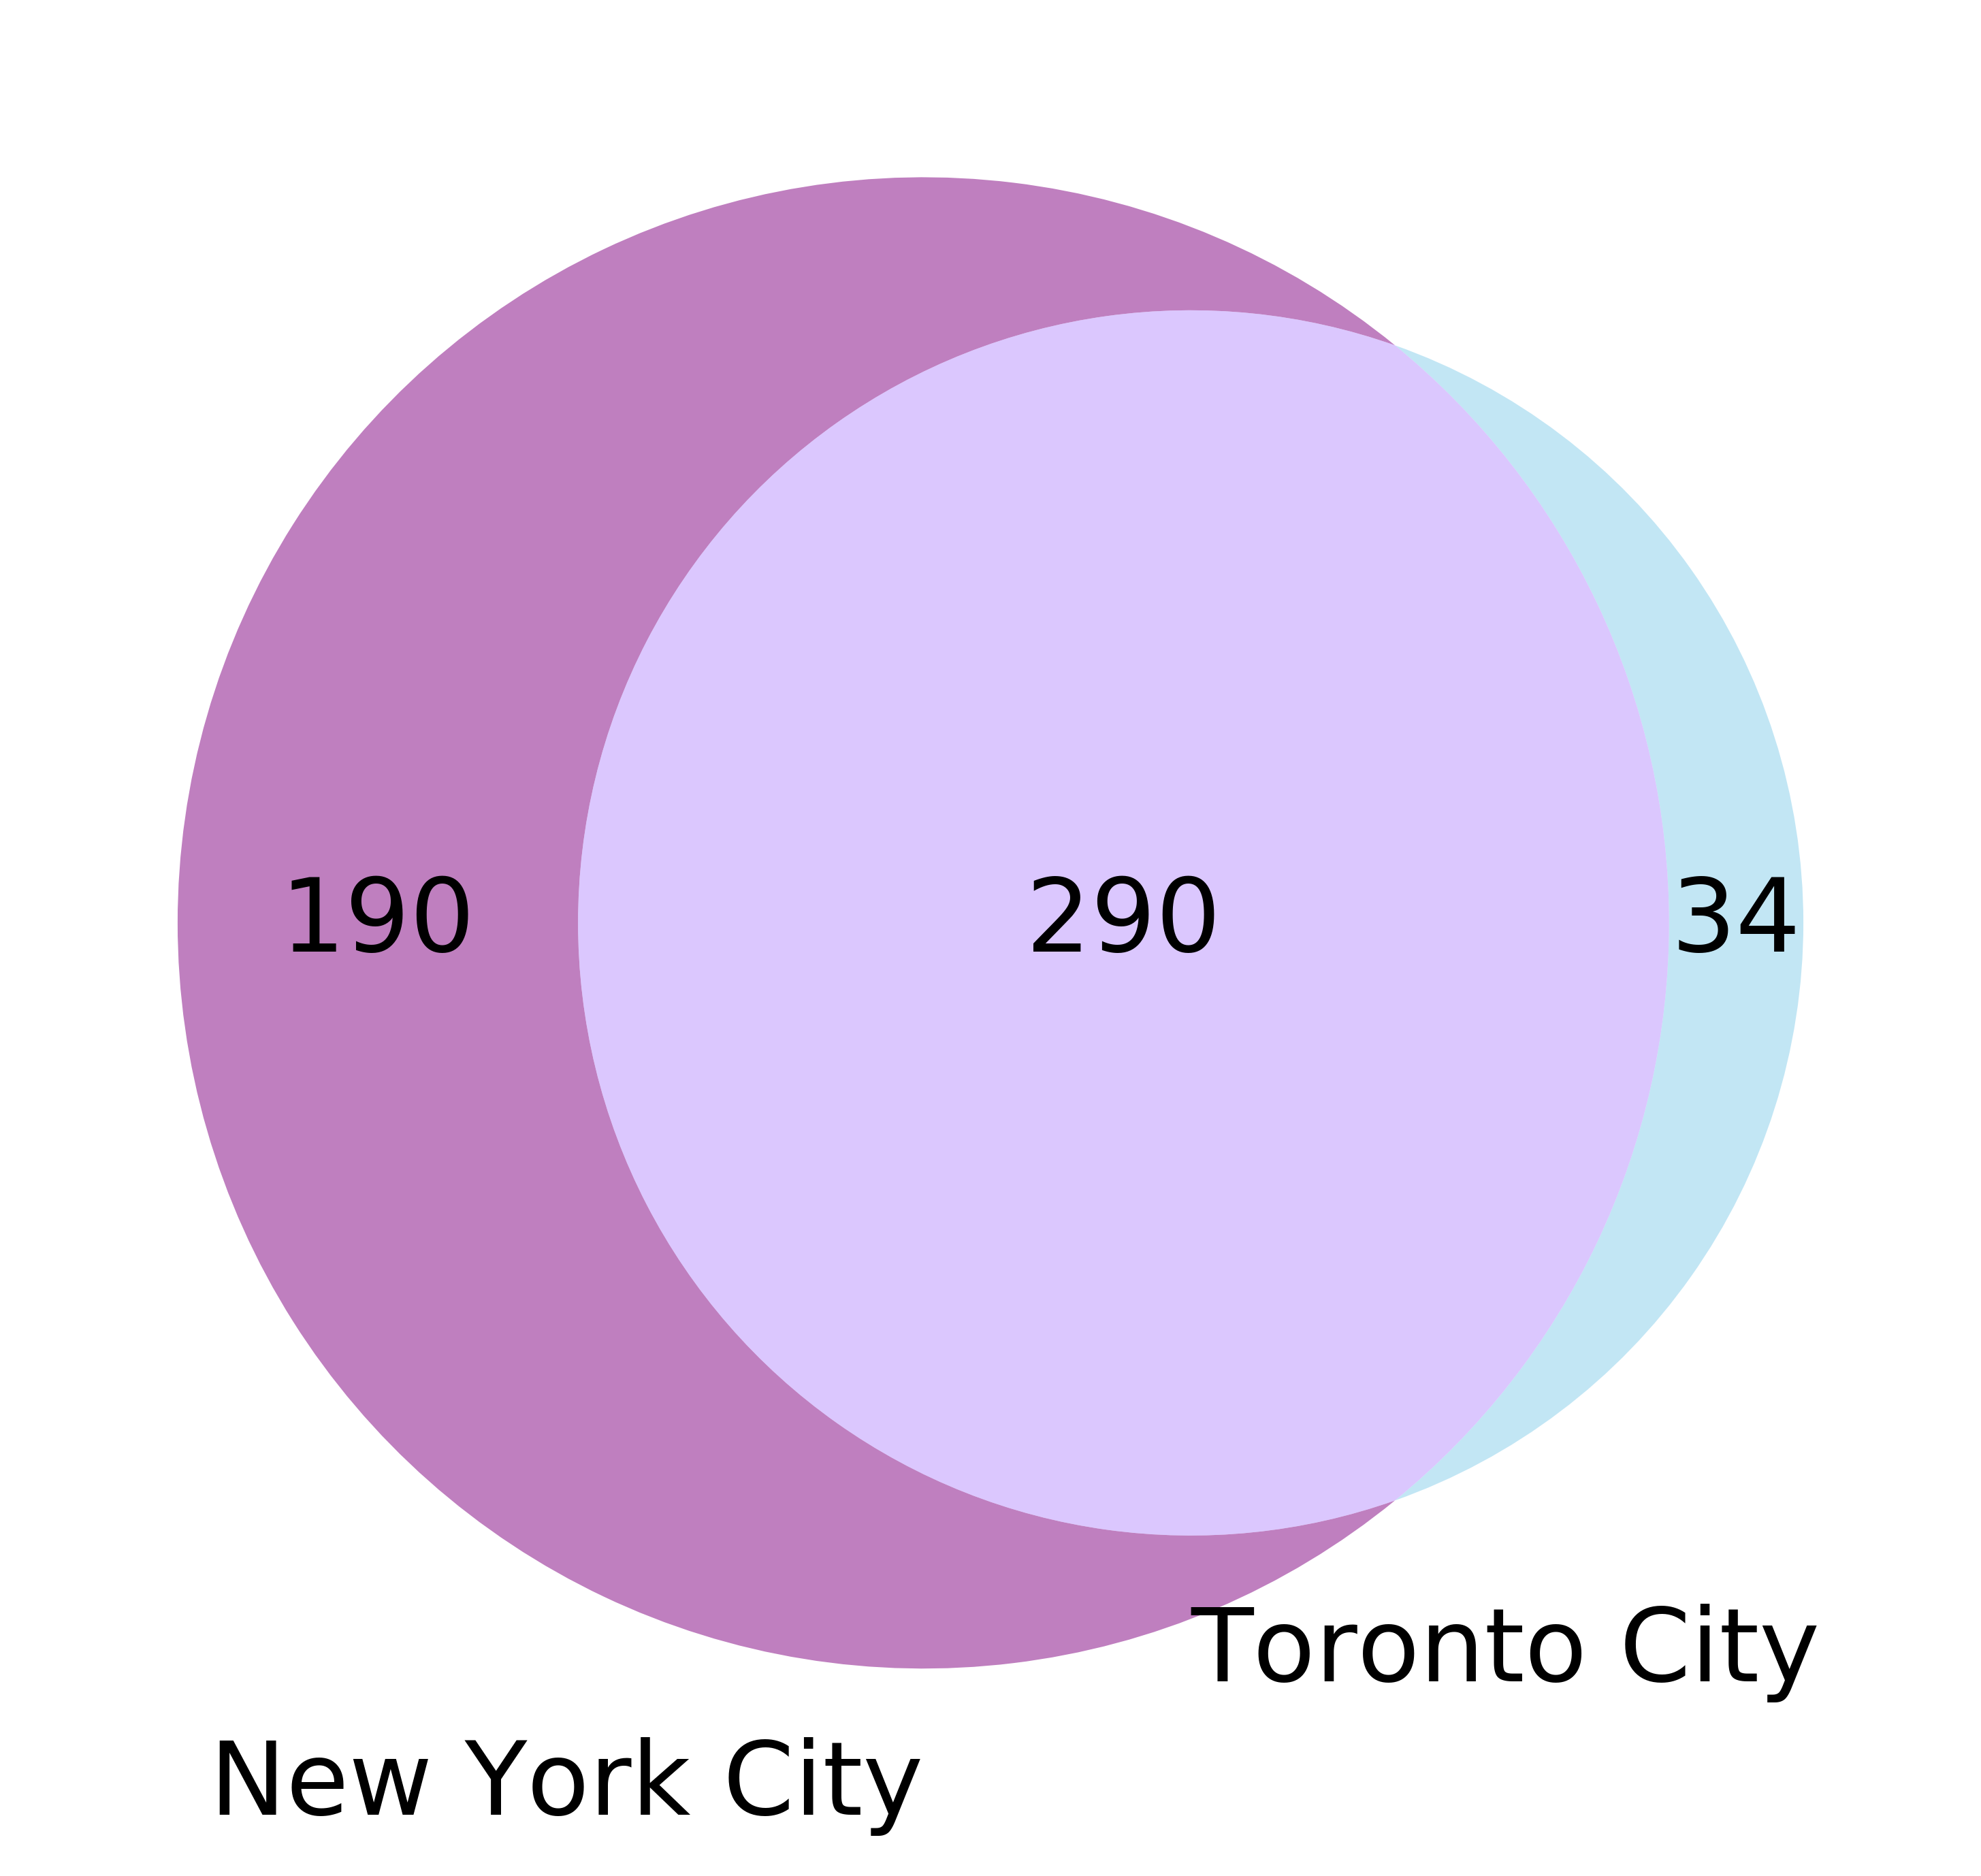

In [175]:
vn1 = set(df1.columns[4:])
vn2 = set(df2.columns[5:])
plt.figure(figsize = (6,6))
out = venn2([set(vn1), set(vn2)], set_labels = ['New York City', 'Toronto City'], set_colors=('purple', 'skyblue'), alpha = 0.5)
for text in out.set_labels:
    text.set_fontsize(18)
for text in out.subset_labels:
    text.set_fontsize(18)
plt.show()

In [176]:
# Drop non-common venues, for this we will be using the df sets

comm_vns = []
for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        comm_vns.append(i)

col1 = list(df1.columns[0:4]) + comm_vns
col2 = list(df2.columns[0:5]) + comm_vns
print('Before removing non-common venues, shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))
df1 = df1.loc[:, col1]
df2 = df2.loc[:, col2]
print('After removing non-common venues, shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))

Before removing non-common venues, shape of New York: (306, 484), and shape of Toronto is: (103, 329)
After removing non-common venues, shape of New York: (306, 294), and shape of Toronto is: (103, 295)


In [177]:
# Functions that uses cosine similarity to find N most similar places between NYC and TO, user defined statement

# Function to add numeric suffix
def ret_order_num(n_most_similar):
    a = ['st', 'nd', 'rd']
    c = []
    for i in range(1,20+1):
        if i == 1:
            c.append(str(i)+str(a[i-1]))
        elif i == 2:
            c.append(str(i)+str(a[i-1]))
        elif i == 3:
            c.append(str(i)+str(a[i-1]))
        else:
            c.append(str(i)+'th')
    return c

def most_similar_borough(cur_city, cur_borough, cur_neigh, n_most_similar):
    ny_data = df1.iloc[:,4:]
    toronto_data = df2.iloc[:,5:]
    if cur_city.lower() == 'New York'.lower():
        X1 = ny_data.values
        X2 = toronto_data.values
        index = df1.loc[(df1['Borough'] == cur_borough) 
                        & (df1['Neighbourhood'] == cur_neigh)].index.values.astype(int)[0]
        lat = df1.loc[index]['Latitude']
        lon = df1.loc[index]['Longitude']
    else:
        X1 = toronto_data.values
        X2 = ny_data.values
        index = df2.loc[(df2['Borough'] == cur_borough) 
                & (df2['Neighbourhood'] == cur_neigh)].index.values.astype(int)[0]
        lat = df2.loc[index]['Latitude']
        lon = df2.loc[index]['Longitude']
    
    a = np.matmul(X1[index], X2.T)
    aa = np.argsort(-a)[0:n_most_similar]
    if cur_city.lower() == 'New York'.lower():
        my_brgh = df2.iloc[aa, :]
    else:
        my_brgh = df1.iloc[aa, :]
            
    c = ret_order_num(n_most_similar)
    
    current_location_popup = '{}, {}, {}'.format(cur_neigh, cur_borough, cur_city)
    loclabl = folium.Popup(current_location_popup, parse_html=True)
    
    my_map = folium.Map(location = [lat, lon], zoom_start = 6)
    folium.CircleMarker([lat, lon], color = 'red', radius = 5,
                        popup = loclabl, fill_color = '#3186cc', fill_opacity = 1,
                        fill = True, tooltip = 'current location').add_to(my_map)

    # add markers to map
    for lat, lng, label, priority in zip(my_brgh['Latitude'], my_brgh['Longitude'], 
                                         my_brgh['Neighbourhood'], c):
        label = folium.Popup(label, parse_html=True)
        folium.Marker([lat, lng], radius = 5, popup=label, color='blue', 
                      tooltip = priority, parse_html=False).add_to(my_map)  

    print('Using Cosine Similarity, we found out that the 10 most similar Neighbourhood to:', Cos_Neigh,",", Cos_Borough, 'are the following, \nin descending order:')

    for i in my_brgh:
        cos_top10 = my_brgh[['Borough', 'Neighbourhood']]
    print(cos_top10)
    return my_map

In [178]:
Cos_Neigh = 'East Village'
Cos_Borough = "Manhattan"
Cos_City = 'New York'

most_similar_borough(cur_city = Cos_City, cur_borough = Cos_Borough,
                     cur_neigh = Cos_Neigh, n_most_similar = 10)

Using Cosine Similarity, we found out that the 10 most similar Neighbourhood to: East Village , Manhattan are the following, 
in descending order:
        Borough                                      Neighbourhood
11    Etobicoke                                          Northwest
89  Scarborough                                             Woburn
76   North York                                     Downsview West
74   North York                    Northwood Park, York University
3     Etobicoke  Humber Bay, King's Mill Park, Kingsway Park So...
83   North York                 Downsview, North Park, Upwood Park
94  Scarborough    Cliffcrest, Cliffside, Scarborough Village West
10    Etobicoke  Albion Gardens, Beaumond Heights, Humbergate, ...
71   North York                                    Don Mills North
91  Scarborough                                Scarborough Village


# Returning to the main project at hand, the code cells above refer to an alternate methodology, using Cosine Similarity

In [31]:
# Here, we define a function in order to return the first N most common venues
def return_most_common_venues(row, start_col, n_top_cat):
    row_categories = row.iloc[start_col:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:n_top_cat]

In [32]:
# create columns according to number of top venues
n_top_cat = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighbourhood']

for ind in np.arange(n_top_cat):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nyc_top_cat = pd.DataFrame(columns=columns)
nyc_top_cat['Neighbourhood'] = ny_df['Neighbourhood']

for ind in np.arange(ny_df.shape[0]):
    nyc_top_cat.iloc[ind, 1:] = return_most_common_venues(ny_df.iloc[ind, :], 3, n_top_cat)

nyc_top_cat.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,St. George,Pizza Place,Deli / Bodega,Italian Restaurant,Clothing Store,Bar,Brewery,Park,Train Station,Harbor / Marina,Thrift / Vintage Store
1,New Brighton,Bar,Italian Restaurant,Pizza Place,Donut Shop,Mexican Restaurant,Thrift / Vintage Store,Baseball Stadium,Pharmacy,Sandwich Place,Garden Center
2,Stapleton,Pizza Place,Sandwich Place,Mexican Restaurant,Discount Store,Bank,Fast Food Restaurant,New American Restaurant,Sri Lankan Restaurant,Harbor / Marina,Gym / Fitness Center
3,Rosebank,Bus Stop,Italian Restaurant,Intersection,Bar,Mexican Restaurant,Beach,Grocery Store,Pizza Place,Chinese Restaurant,Eastern European Restaurant
4,West Brighton,Pizza Place,Italian Restaurant,Coffee Shop,Bagel Shop,Ice Cream Shop,Pharmacy,Salon / Barbershop,Sandwich Place,Fast Food Restaurant,Bus Stop


## Clustering NYC
Now we apply K-Means Clustering for our dataframe for NYC, which includes the relative frequency of each venue per neighbourhood

In [98]:
ny_df.head()

,Borough,Neighbourhood,Latitude,Longitude,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini

In [91]:
# set number of clusters
kclusters = 4

nyc_clust = ny_df.drop(['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] , 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_clust)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 2, 1, 1, 1, 2, 0, 1, 1])

In [92]:
# add clustering labels
nyc_top_cat.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = ny_df.iloc[:, :4]

# merge nyc_merged with nyc_top_cat to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(nyc_top_cat.set_index('Neighbourhood'), on='Neighbourhood')

nyc_merged.head()

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Staten Island,St. George,40.644982,-74.079353,2,Pizza Place,Deli / Bodega,Italian Restaurant,Clothing Store,Bar,Brewery,Park,Train Station,Harbor / Marina,Thrift / Vintage Store
1,Staten Island,New Brighton,40.640615,-74.087017,2,Bar,Italian Restaurant,Pizza Place,Donut Shop,Mexican Restaurant,Thrift / Vintage Store,Baseball Stadium,Pharmacy,Sandwich Place,Garden Center
2,Staten Island,Stapleton,40.626928,-74.077902,2,Pizza Place,Sandwich Place,Mexican Restaurant,Discount Store,Bank,Fast Food Restaurant,New American Restaurant,Sri Lankan Restaurant,Harbor / Marina,Gym / Fitness Center
3,Staten Island,Rosebank,40.615305,-74.069805,2,Bus Stop,Italian Restaurant,Intersection,Bar,Mexican Restaurant,Beach,Grocery Store,Pizza Place,Chinese Restaurant,Eastern European Restaurant
4,Staten Island,West Brighton,40.631879,-74.107182,2,Pizza Place,Italian Restaurant,Coffee Shop,Bagel Shop,Ice Cream Shop,Pharmacy,Salon / Barbershop,Sandwich Place,Fast Food Restaurant,Bus Stop


In [93]:
# create map
nyc_clusters = folium.Map(location=[lat, lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighbourhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(nyc_clusters)
       
nyc_clusters

In [95]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, 
               nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,South Beach,Pier,Beach,American Restaurant,Bus Stop,Park,Baseball Field,Athletics & Sports,Food,Playground,Soccer Field
38,Butler Manor,Baseball Field,Beach,Convenience Store,Grocery Store,Pool,Deli / Bodega,Falafel Restaurant,Farm,Farmers Market,Fish & Chips Shop
106,Breezy Point,Surf Spot,Beach,American Restaurant,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
111,Arverne,Surf Spot,Beach,Deli / Bodega,Bus Stop,Donut Shop,Sandwich Place,Grocery Store,Bank,Metro Station,Gym / Fitness Center
112,Rockaway Beach,Beach,Bar,Ice Cream Shop,Bagel Shop,Pharmacy,Boat or Ferry,Latin American Restaurant,Pizza Place,Food Truck,Board Shop
113,Neponsit,Beach,Deli / Bodega,Pub,Spa,Bus Stop,Boutique,Park,Chinese Restaurant,Harbor / Marina,Mexican Restaurant
124,Belle Harbor,Beach,Pub,Bakery,Boutique,Harbor / Marina,Smoke Shop,Chinese Restaurant,Trail,Bagel Shop,Pharmacy
125,Rockaway Park,Beach,Pizza Place,Donut Shop,Deli / Bodega,Bar,Bagel Shop,Bank,Pub,Pharmacy,Mediterranean Restaurant
138,Roxbury,Art Gallery,Theater,Beach,Baseball Field,Irish Pub,Sports Club,Pier,Fast Food Restaurant,Deli / Bodega,Snack Place
141,Hammels,Beach,Surf Spot,Fast Food Restaurant,Bar,Supermarket,Wine Bar,Board Shop,Donut Shop,Coffee Shop,Pizza Place


In [97]:
to_df.head()

,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Lab,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Souvlaki Shop,Spa,Speakeasy,Sport

## Clustering Toronto
Now we apply K-Means Clustering for our dataframe for Toronto, which includes the relative frequency of each venue per neighbourhood

In [99]:
# We first create a table with the 10 most common venues

# create columns according to number of top venues
n_top_cat = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighbourhood']

for ind in np.arange(n_top_cat):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
to_top_cat = pd.DataFrame(columns=columns)
to_top_cat['Neighbourhood'] = to_df['Neighbourhood']

for ind in np.arange(to_df.shape[0]):
    to_top_cat.iloc[ind, 1:] = return_most_common_venues(to_df.iloc[ind, :], 3, n_top_cat)

to_top_cat.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Humber Bay Shores, Mimico South, New Toronto",Park,Bakery,Fried Chicken Joint,Dessert Shop,Pharmacy,Grocery Store,Gym,Italian Restaurant,Liquor Store,Mexican Restaurant
1,"Alderwood, Long Branch",Discount Store,Pharmacy,Pizza Place,Park,Donut Shop,Garden Center,Liquor Store,Convenience Store,Moroccan Restaurant,Skating Rink
2,"The Kingsway, Montgomery Road, Old Mill North",Coffee Shop,Italian Restaurant,Park,Sushi Restaurant,Pizza Place,Bank,Dessert Shop,Burger Joint,Breakfast Spot,French Restaurant
3,"Humber Bay, King's Mill Park, Kingsway Park So...",Italian Restaurant,Park,Shopping Mall,Ice Cream Shop,Eastern European Restaurant,Gym / Fitness Center,Farm,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant
4,"Kingsway Park South West, Mimico NW, The Queen...",Restaurant,Coffee Shop,Burrito Place,Gym / Fitness Center,Bakery,Italian Restaurant,Bank,Convenience Store,Yoga Studio,Grocery Store


In [103]:
# set number of clusters
kclusters = 5

to_clust = to_df.drop(['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] , 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(to_clust)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 0, 4, 0, 2, 2, 0, 2, 2])

In [104]:
# add clustering labels
#to_top_cat.insert(0, 'Cluster Labels', kmeans.labels_)

to_merged = to_df.iloc[:, :4]

# merge nyc_merged with nyc_top_cat to add latitude/longitude for each neighborhood
to_merged = to_merged.join(to_top_cat.set_index('Neighbourhood'), on='Neighbourhood')

to_merged.head()

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Etobicoke,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,0,Park,Bakery,Fried Chicken Joint,Dessert Shop,Pharmacy,Grocery Store,Gym,Italian Restaurant,Liquor Store,Mexican Restaurant
1,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,2,Discount Store,Pharmacy,Pizza Place,Park,Donut Shop,Garden Center,Liquor Store,Convenience Store,Moroccan Restaurant,Skating Rink
2,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,0,Coffee Shop,Italian Restaurant,Park,Sushi Restaurant,Pizza Place,Bank,Dessert Shop,Burger Joint,Breakfast Spot,French Restaurant
3,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509,0,Italian Restaurant,Park,Shopping Mall,Ice Cream Shop,Eastern European Restaurant,Gym / Fitness Center,Farm,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant
4,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999,0,Restaurant,Coffee Shop,Burrito Place,Gym / Fitness Center,Bakery,Italian Restaurant,Bank,Convenience Store,Yoga Studio,Grocery Store


In [105]:
# create map
to_clusters = folium.Map(location=[lat, lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Latitude'], to_merged['Longitude'], to_merged['Neighbourhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(to_clusters)
       
to_clusters

In [109]:
to_merged.loc[to_merged['Cluster Labels'] == 1, 
               to_merged.columns[[1] + list(range(5, to_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,Downsview Central,Vietnamese Restaurant,Food Truck,Baseball Field,Fast Food Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm


# EDA

### Examining our findings

#### Let's explore our data

In [ ]:
# @hidden_cell
# plotting configurations found in the course's modules

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    
# table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

### Most Common Venues in NYC

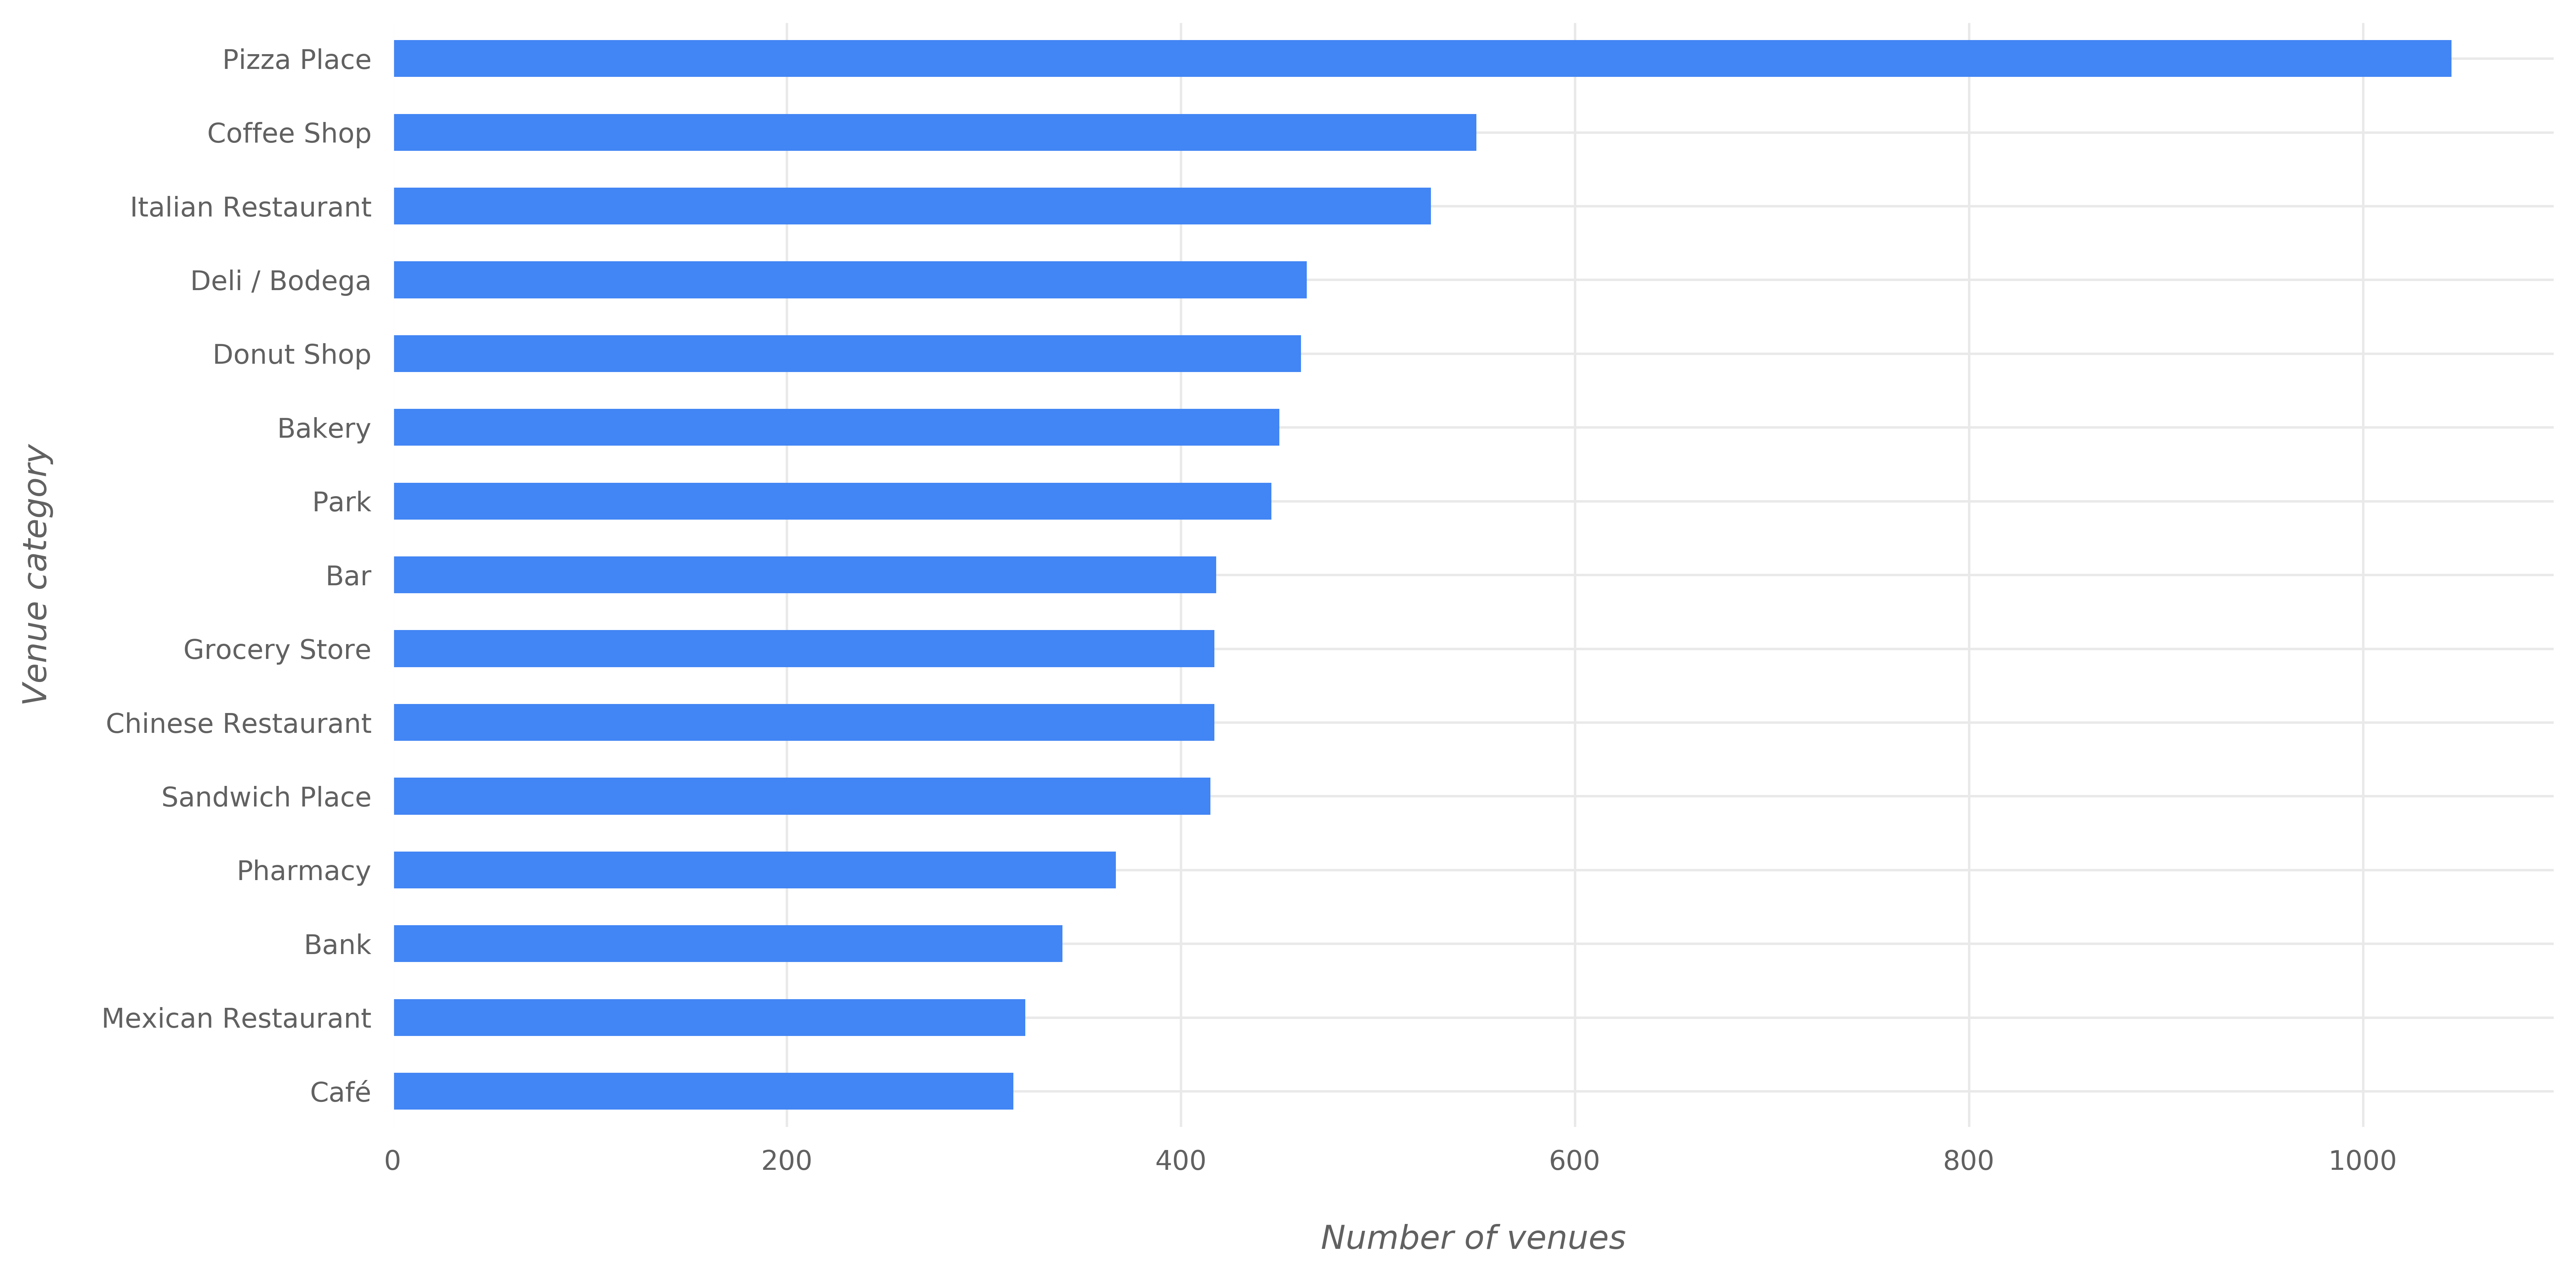

In [148]:
nyc_venues = get_near_by_venues(names=ny_df['Neighbourhood'],
                                latitudes=ny_df['Latitude'],
                                longitudes=ny_df['Longitude']
                                )

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_top_vc = nyc_venues['Venue Category'].value_counts(normalize=False)
ax = nyc_top_vc.head(15).plot(kind='barh', color=pc[0]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of Venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)

## Most Common Venues in Toronto

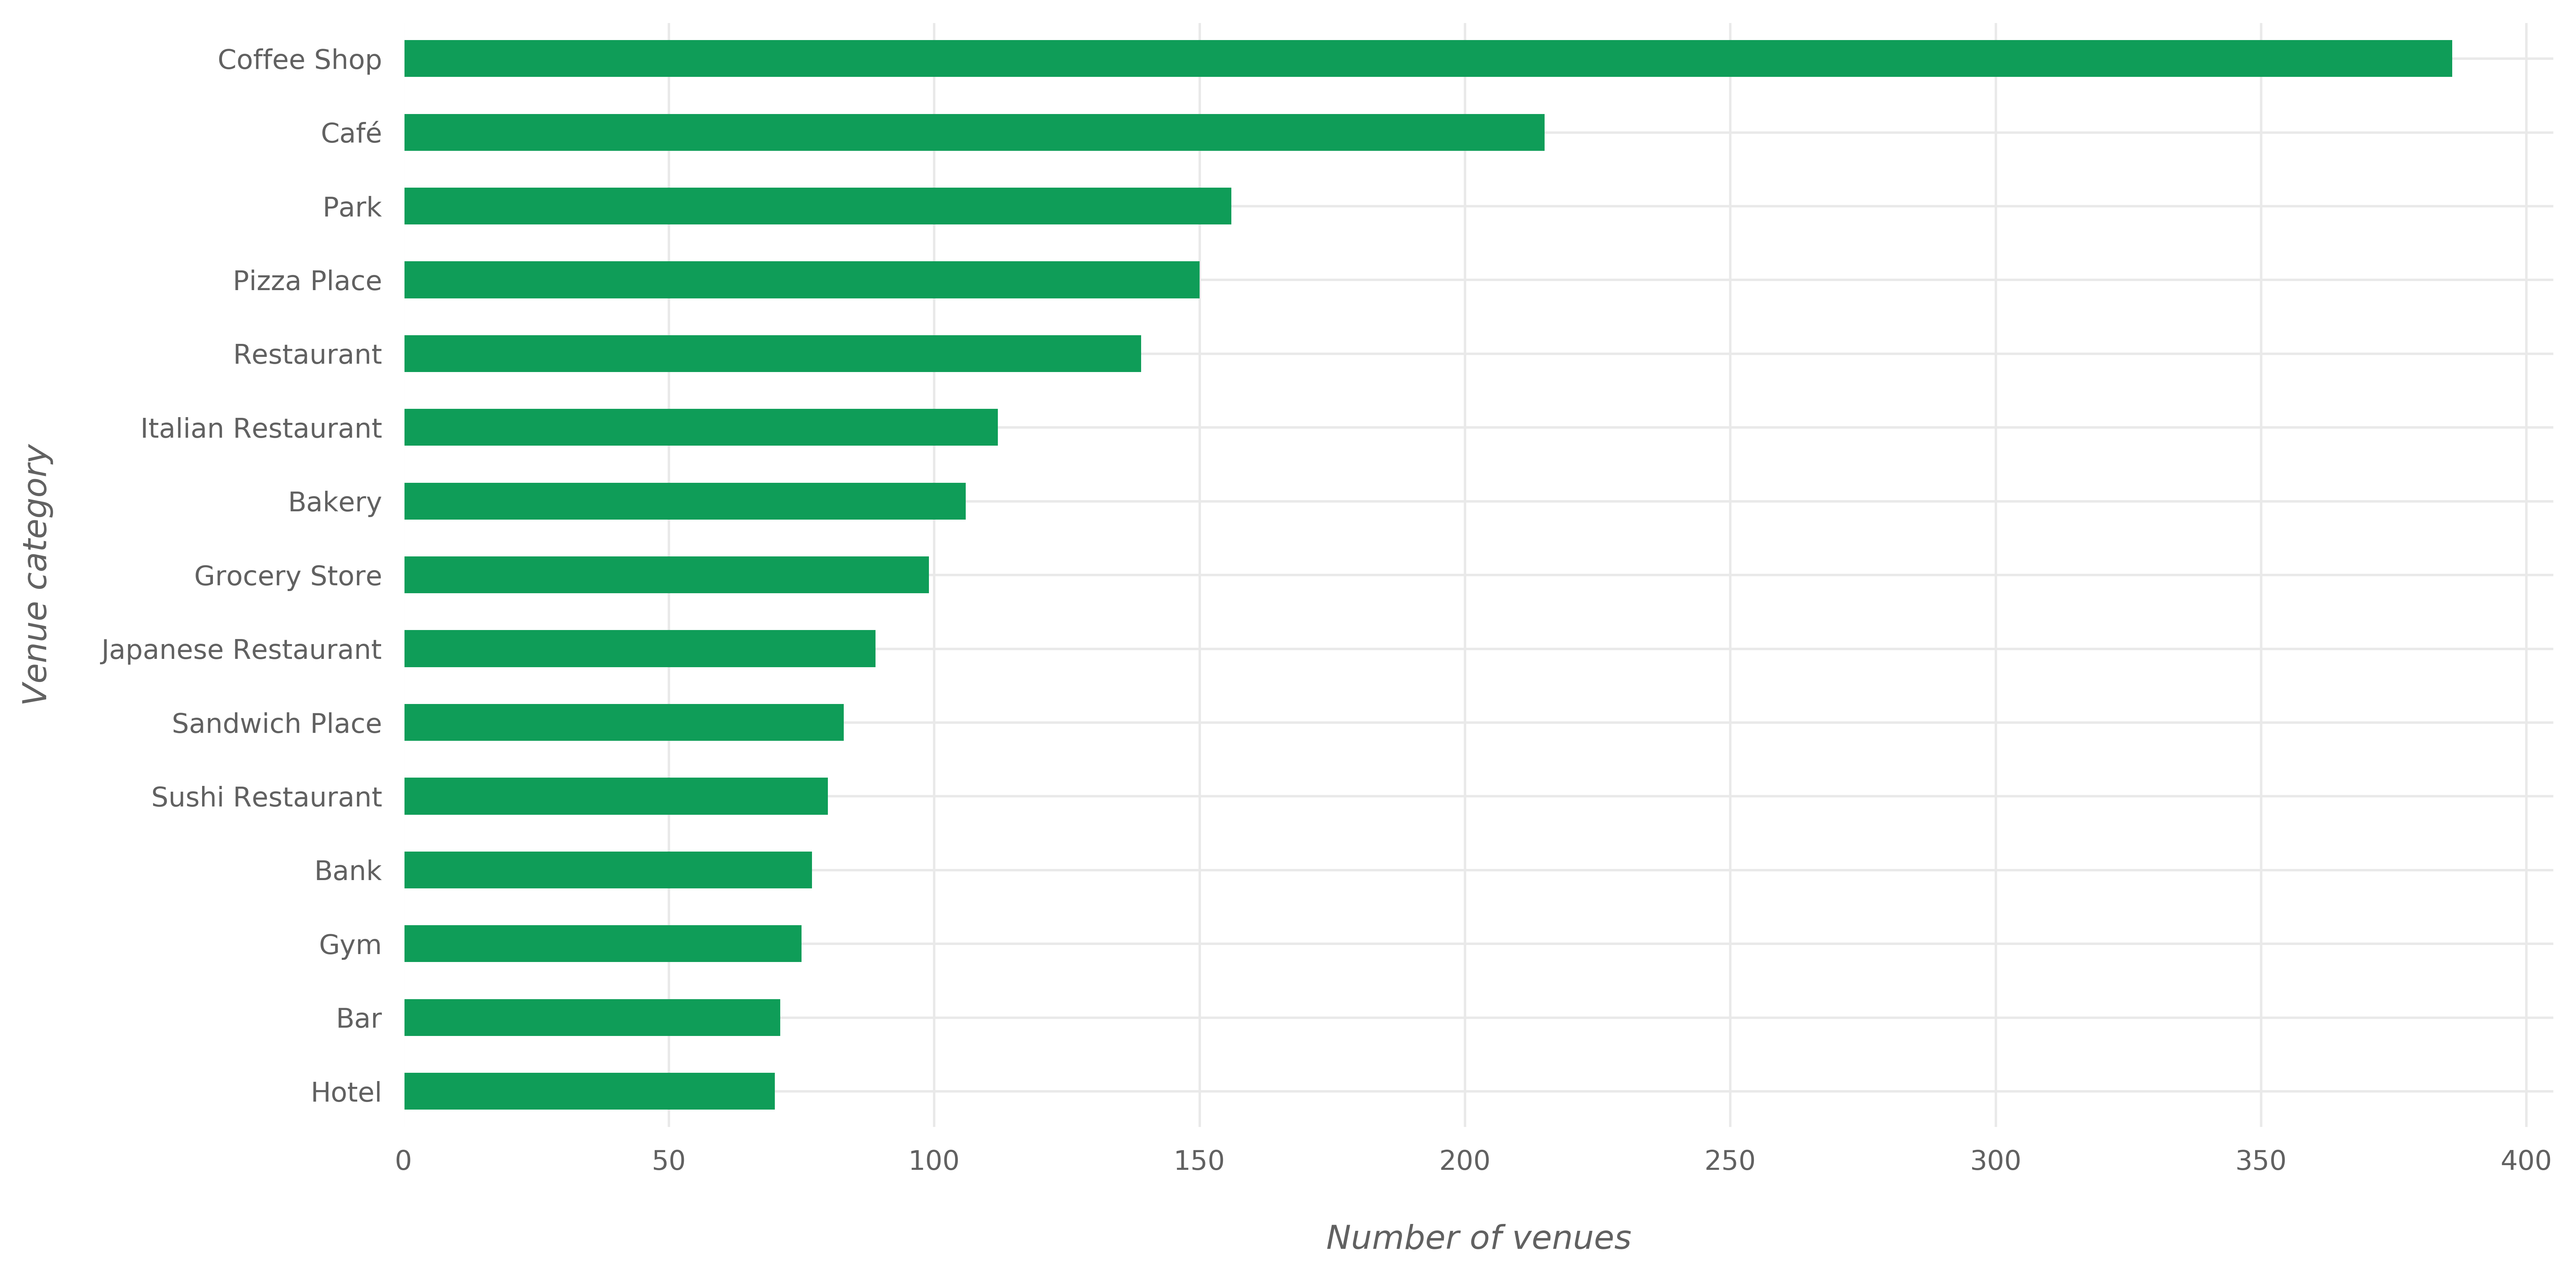

In [149]:
to_venues = get_near_by_venues(names=to_df['Neighbourhood'],
                                latitudes=to_df['Latitude'],
                                longitudes=to_df['Longitude']
                                )

fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_top_vc = to_venues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color=pc[3]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)


306 neighbourhoods in NYC


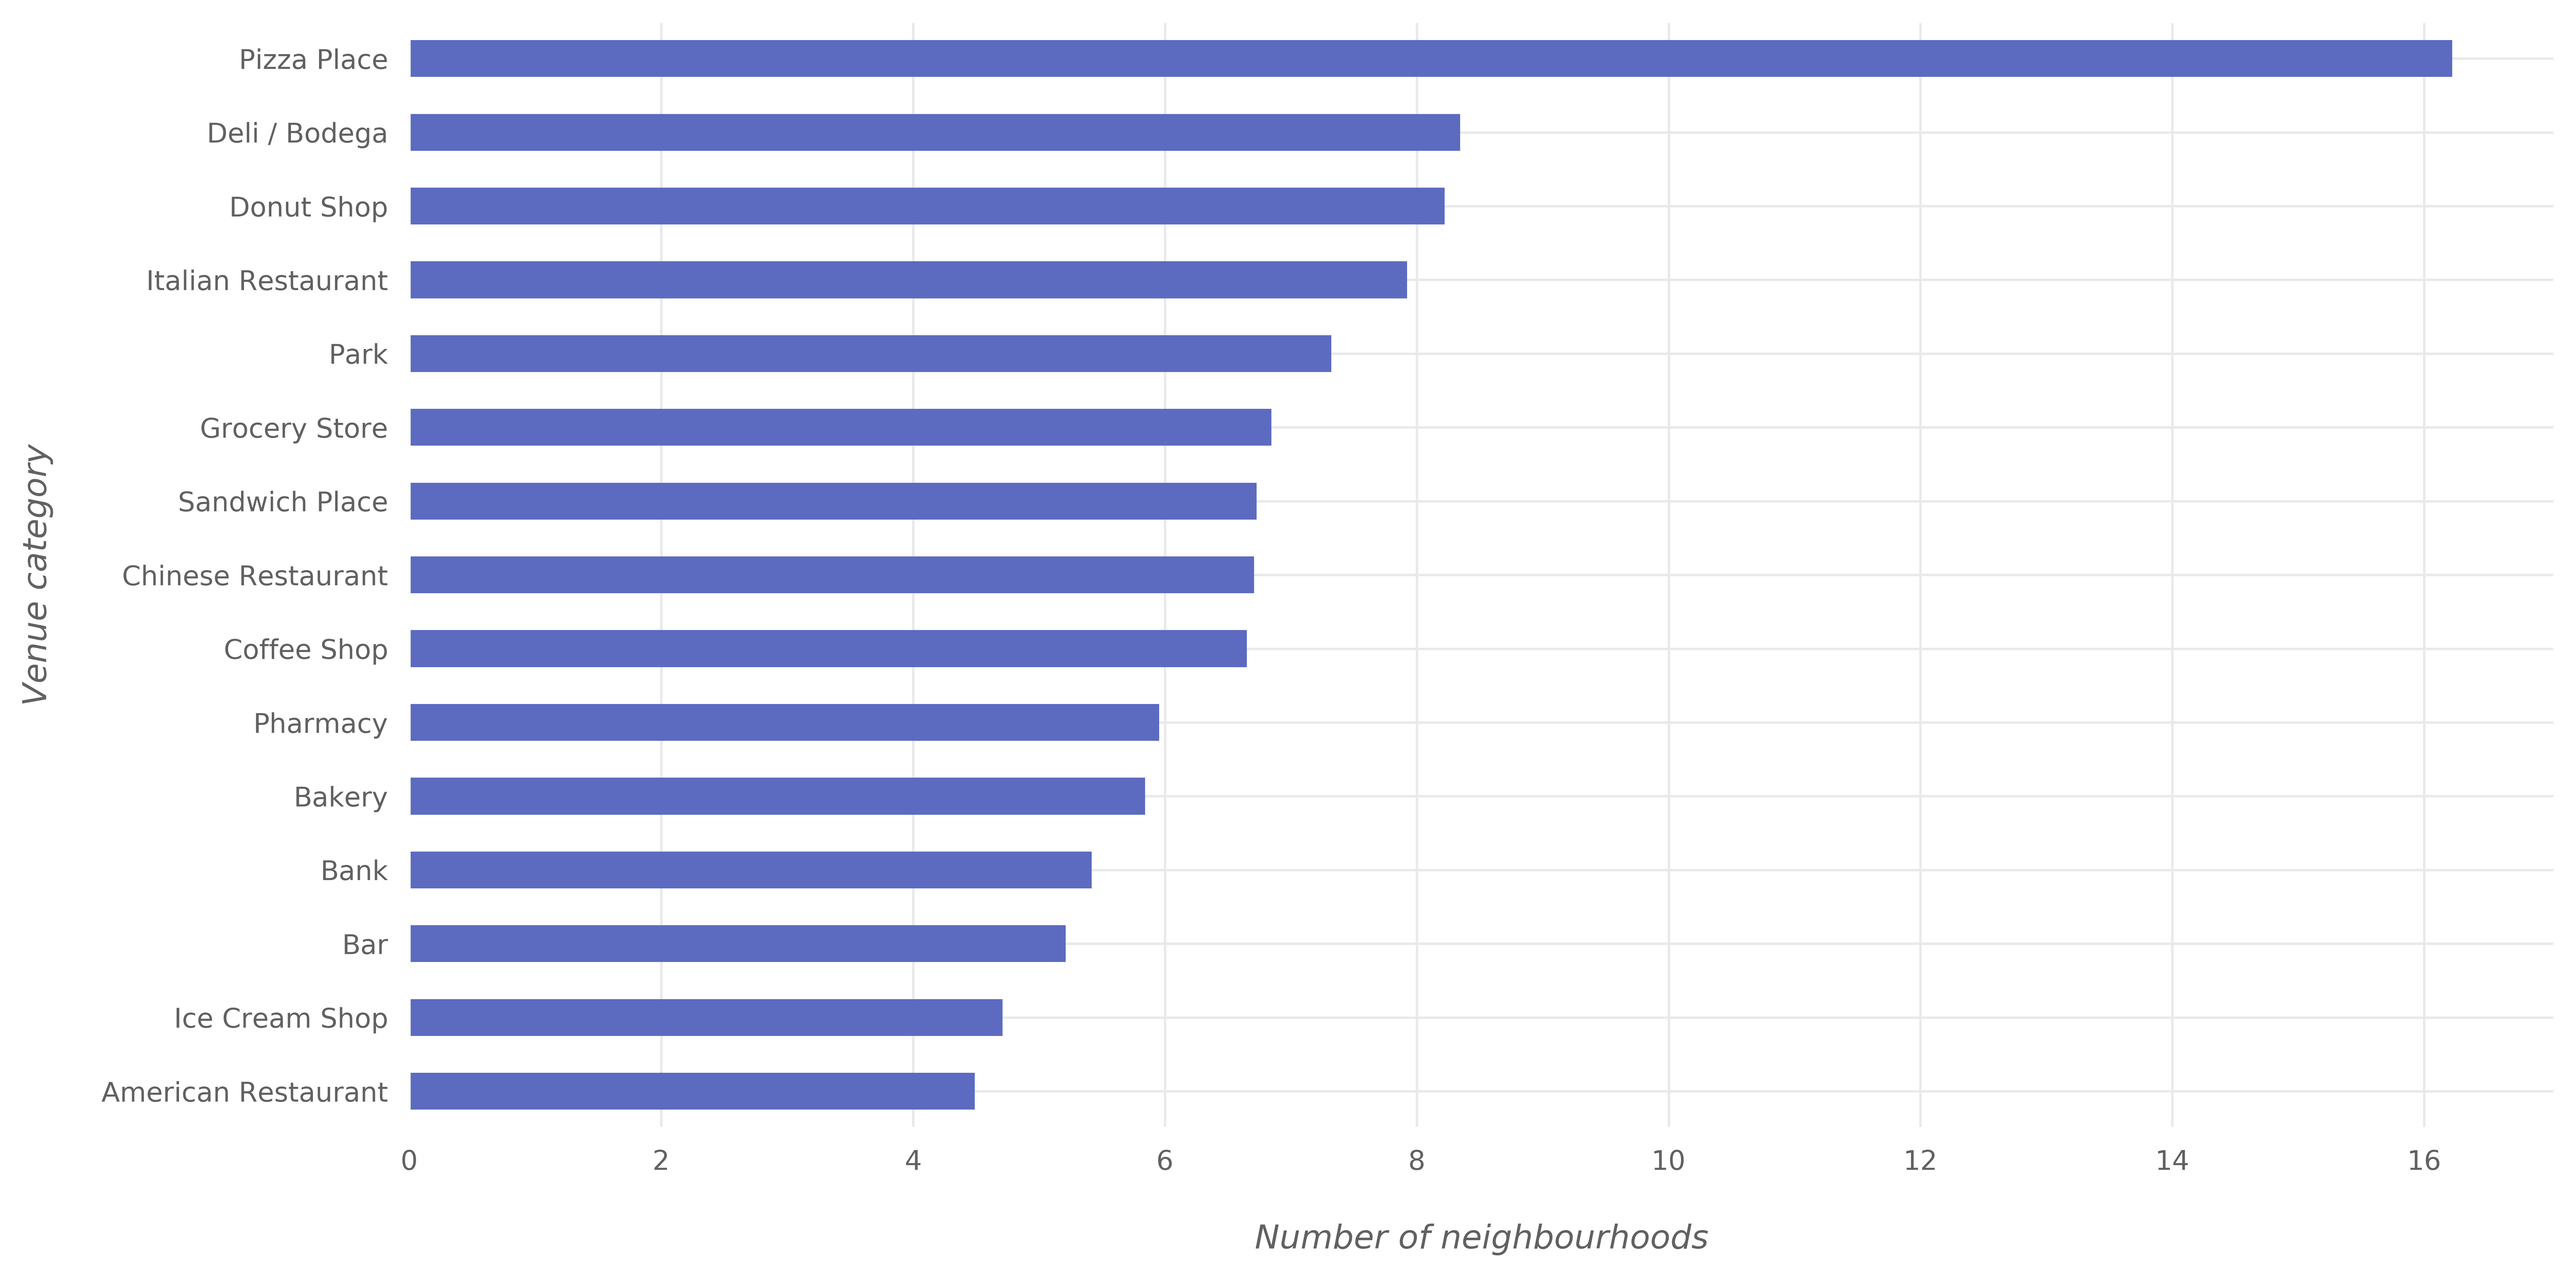

In [115]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_g = ny_df.groupby('Neighbourhood').max().reset_index()
nyc_p = nyc_g.drop(['Borough', 'Neighbourhood', 'Latitude', 'Longitude'], axis=1).sum().sort_values(ascending=False)
print("{} neighbourhoods in NYC".format(nyc_g.shape[0]))
ax = nyc_p.head(15).plot(kind='barh', color=pc[8]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of Neighbourhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-nyc.png', dpi=300)

103 neighbourhoods in Toronto


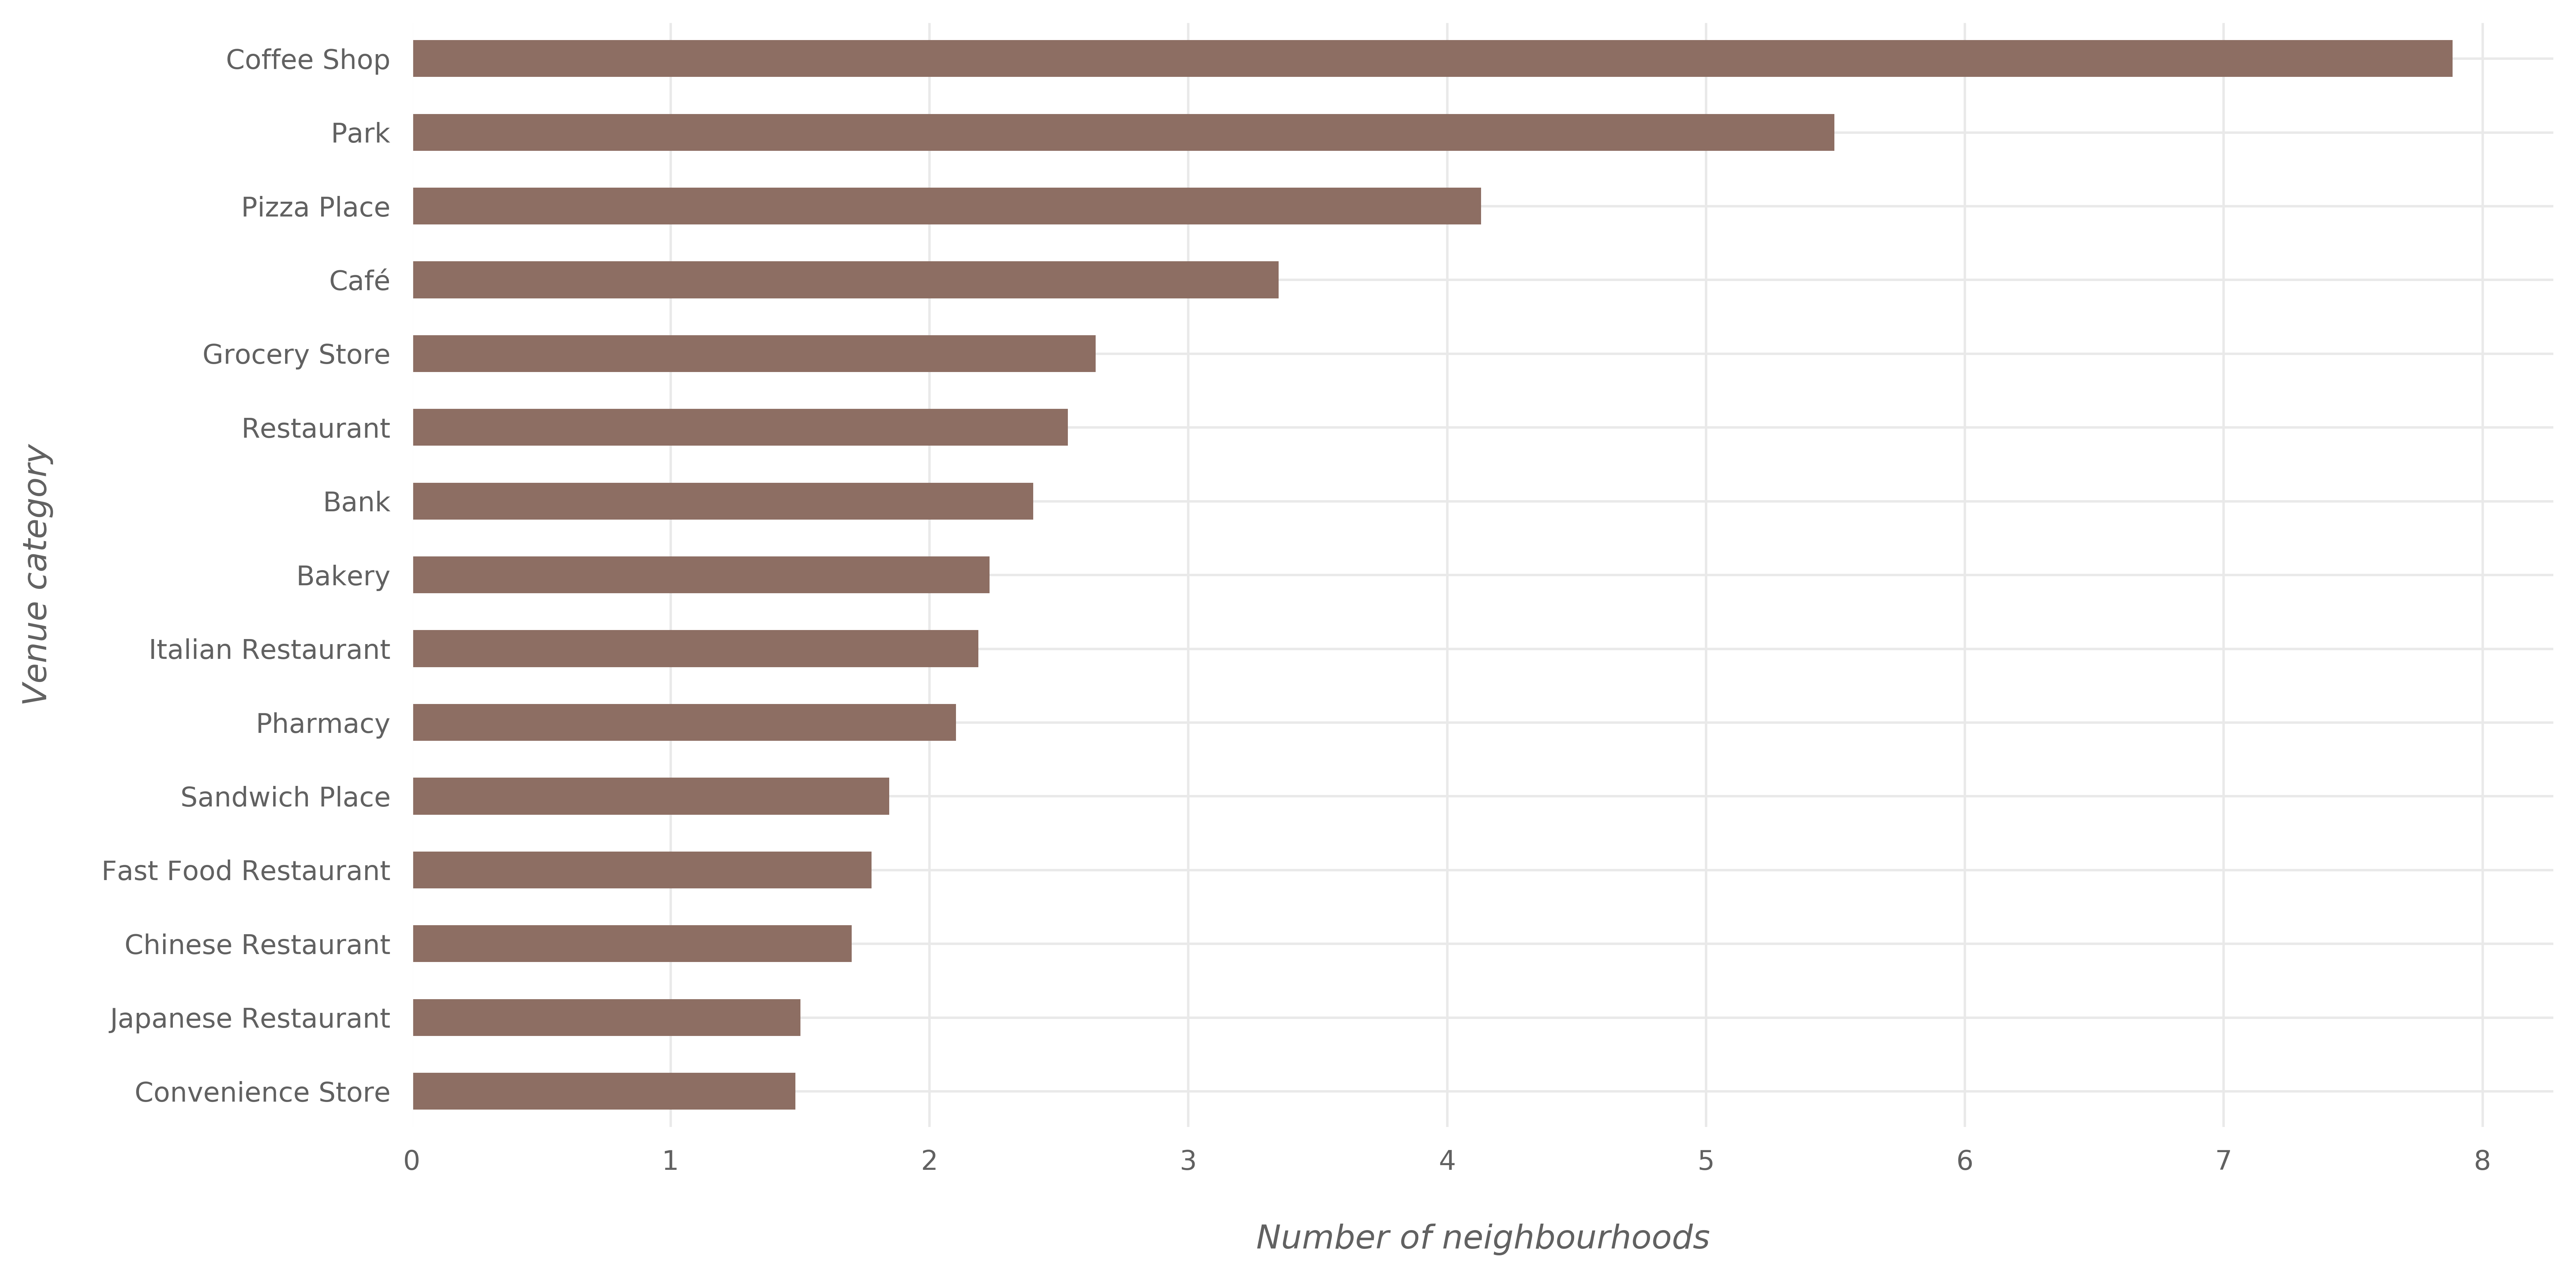

In [120]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_g = to_df.groupby('Neighbourhood').max().reset_index()
tor_p = tor_g.drop(['Borough', 'Neighbourhood', 'Latitude', 'Longitude'], axis=1).sum().sort_values(ascending=False)
print("{} neighbourhoods in Toronto".format(tor_g.shape[0]))
ax = tor_p.head(15).plot(kind='barh', color=pc[17]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighbourhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-tor.png', dpi=300)

#### Now we'll try and combine the two data sets in order to cluster NYC and Toronto, together! and find similar Neighbourhoods

In [155]:
clmns_nyc_only = set(ny_df.columns).difference(set(to_df.columns))
clmns_tor_only = set(to_df.columns).difference(set(ny_df.columns))
nyc_grouped_ = ny_df.copy()
nyc_grouped_['Neighbourhood'] = nyc_grouped_['Neighbourhood'].apply(lambda x: x + '_NYC')
tor_grouped_ = to_df.copy()
tor_grouped_['Neighbourhood'] = tor_grouped_['Neighbourhood'].apply(lambda x: x + '_Toronto')

for c in clmns_tor_only:
    nyc_grouped_[c] = 0
for c in clmns_nyc_only:
    tor_grouped_[c] = 0
    
all_clmns_sorted = ['Neighbourhood'] + sorted(list(nyc_grouped_.drop(['Borough', 'Neighbourhood', 'Latitude', 'Longitude'], axis=1).columns), key=str.lower)
nyc_grouped_ = nyc_grouped_[all_clmns_sorted]
tor_grouped_ = tor_grouped_[all_clmns_sorted]
    
nyc_tor_grouped = pd.concat([nyc_grouped_, tor_grouped_]).reset_index(drop=True)

In [163]:
nyc_tor_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,ATM,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,BBQ Joint,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Carpet Store,Castle,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Cafeteria,College Gym,College Lab,College Quad,College Rec Center,College Stadium,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,IT Services,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighth

In [165]:
n_top_cat = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighbourhood']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

def return_most_common_venues(row, n_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:n_top_cat]


# obtaining the most popular categories for each neighborhood
nyc_tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_tor_neighborhoods_categories_sorted['Neighbourhood'] = nyc_tor_grouped['Neighbourhood']

for ind in np.arange(nyc_tor_grouped.shape[0]):
    nyc_tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        nyc_tor_grouped.iloc[ind, :], n_top_cat)

nyc_tor_neighborhoods_categories_sorted.head()

,Neighbourhood,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,St. George_NYC,Pizza Place,Clothing Store,Deli / Bodega,Italian Restaurant,Bar,Sandwich Place,Bakery,Thrift / Vintage Store,Brewery,Harbor / Marina
1,New Brighton_NYC,Bar,Italian Restaurant,Pizza Place,Donut Shop,Thrift / Vintage Store,Mexican Restaurant,Tapas Restaurant,Sandwich Place,Baseball Stadium,Toy / Game Store
2,Stapleton_NYC,Sandwich Place,Pizza Place,Bank,Fast Food Restaurant,Discount Store,Mexican Restaurant,Gym / Fitness Center,Pharmacy,Bar,Spanish Restaurant
3,Rosebank_NYC,Italian Restaurant,Bus Stop,Pizza Place,Beach,Mexican Restaurant,Grocery Store,Bar,Intersection,Discount Store,Storage Facility
4,West Brighton_NYC,Pizza Place,Italian Restaurant,Coffee Shop,Bagel Shop,Music Store,Ice Cream Shop,Breakfast Spot,Fast Food Restaurant,Bar,Bank


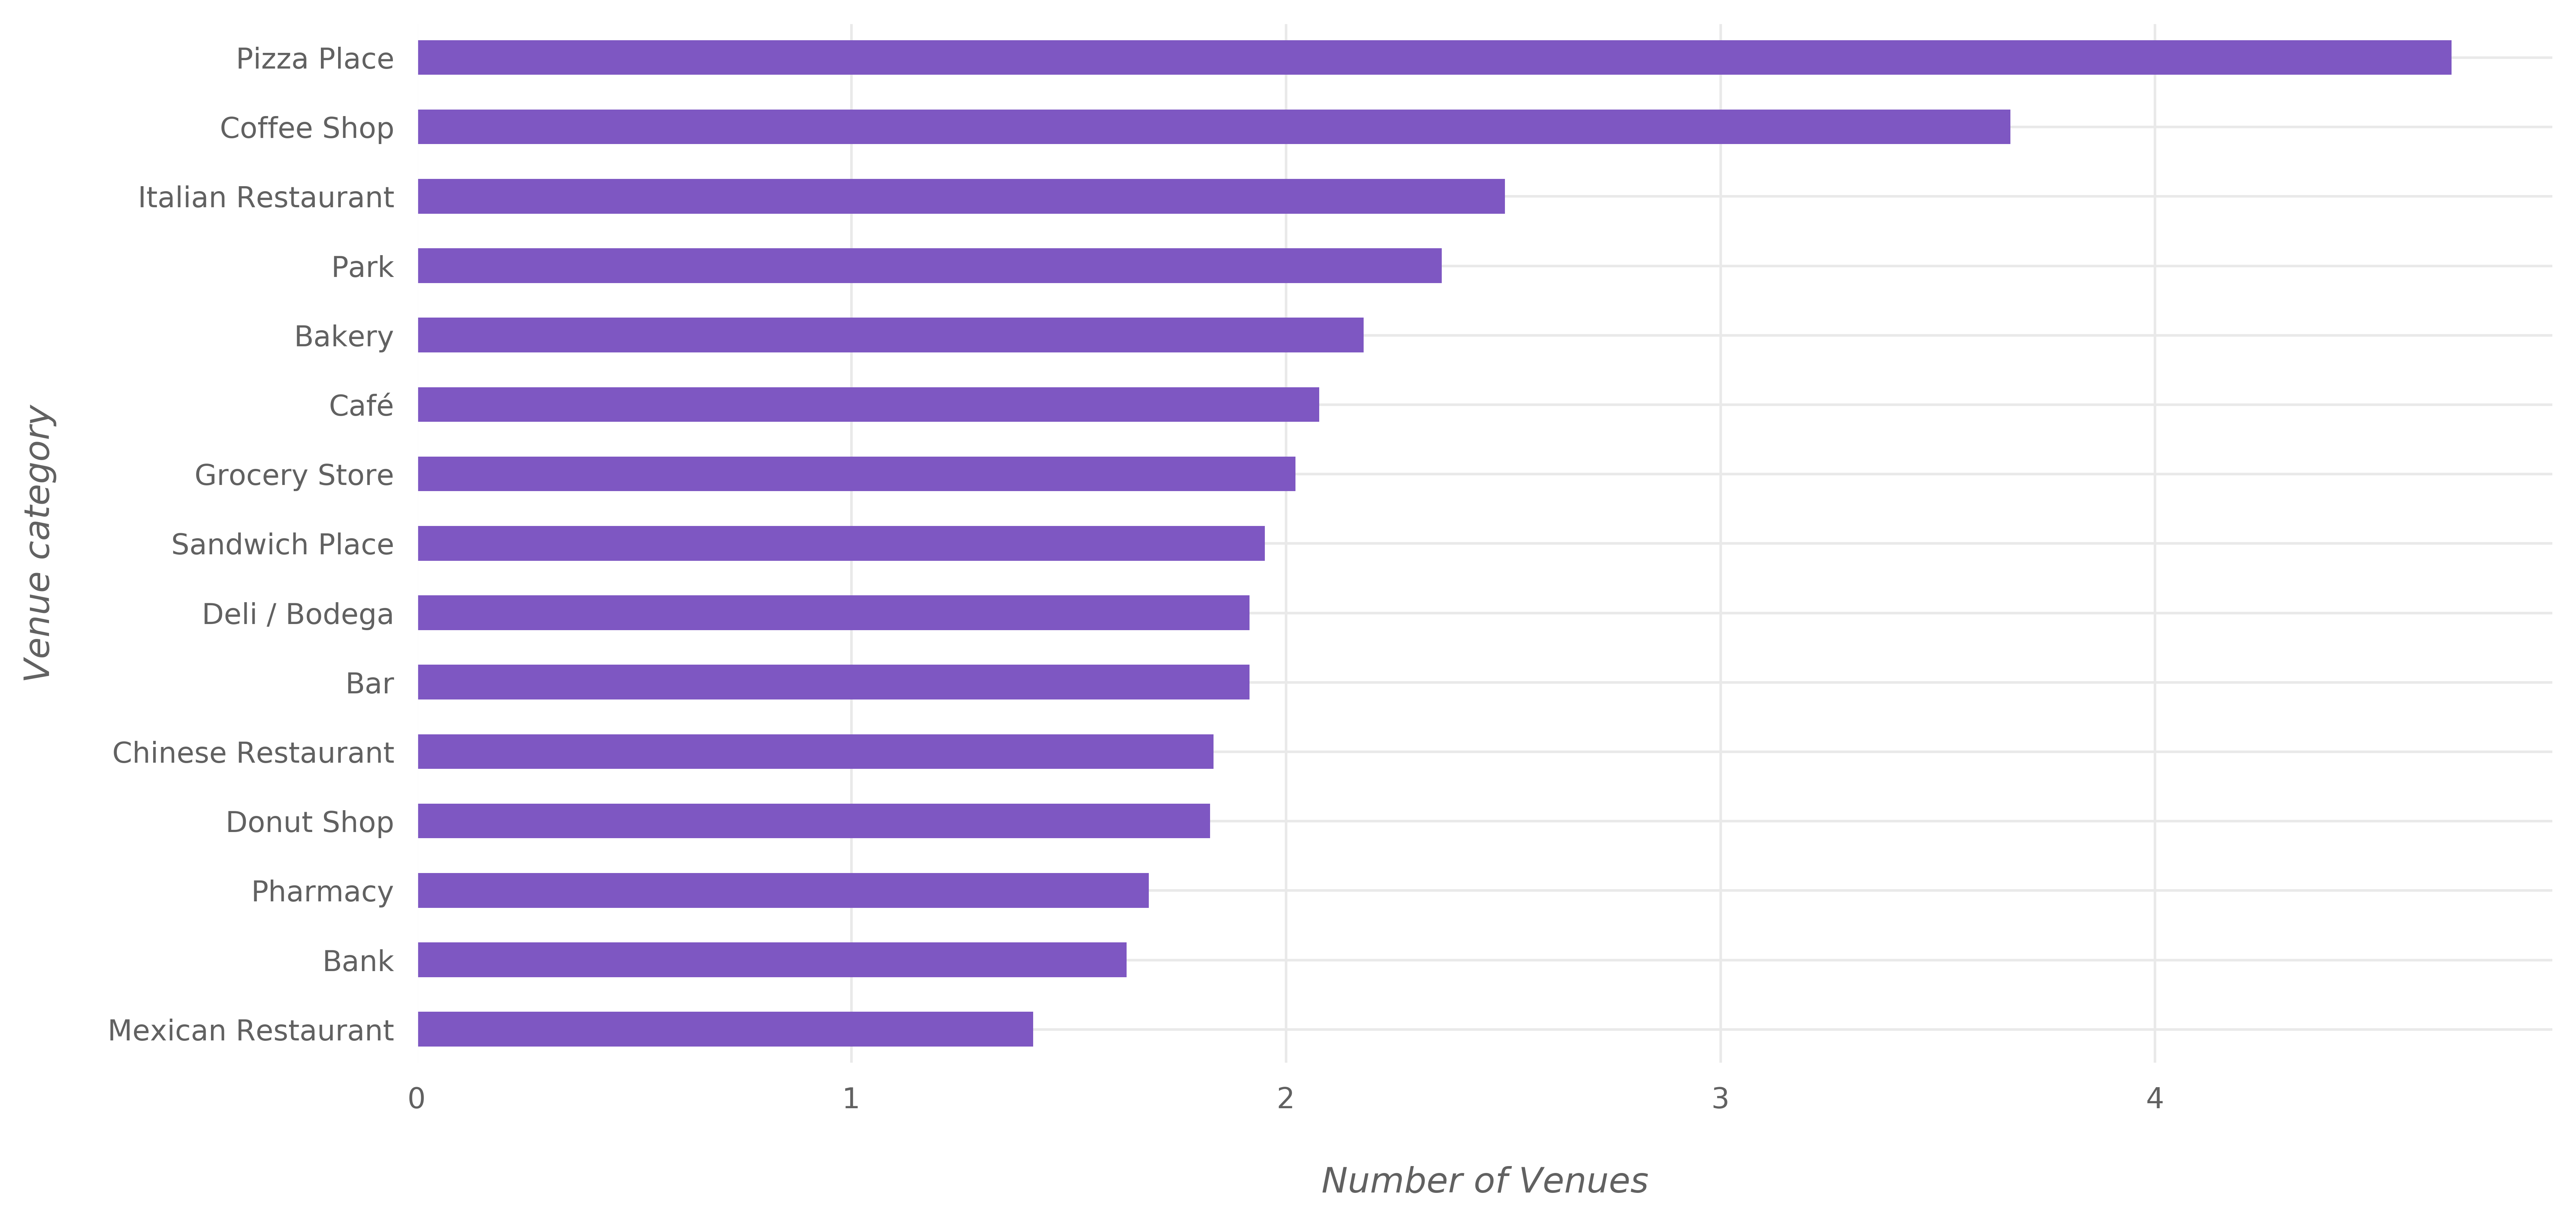

In [169]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
nyc_tor_top_vc = pd.concat([nyc_venues, to_venues])['Venue Category'].value_counts(normalize=True) * 100
ax = nyc_tor_top_vc.head(15).plot(kind='barh', color=pc[12]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of Venues', ylbl='Venue category', t='')
fig.savefig('most-common-ven-nyc-tor.png', dpi=300)

### Clustering NYC % Toronto

In [170]:
# the number of clusters
kclusters = 5

nyc_tor_grouped_clustering = nyc_tor_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 4, 2, 0, 2, 2])

In [173]:
# add clustering labels
nyc_tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# nyc_tor_merged = nyc_tor_neighborhoods.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
# tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_tor_merged = nyc_tor_neighborhoods_categories_sorted.set_index('Neighbourhood')

nyc_tor_merged.iloc[300:310] # check the last columns!

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighbourhood,,,,,,,,,,,
Concourse Village_NYC,3,Sandwich Place,Mexican Restaurant,Donut Shop,Kids Store,Grocery Store,Supermarket,Pizza Place,Sports Bar,Mobile Phone Shop,Gym
Mount Eden_NYC,3,Pizza Place,Grocery Store,Pharmacy,Spanish Restaurant,Chinese Restaurant,Fast Food Restaurant,Food Truck,Bus Station,Gym,Supermarket
Mount Hope_NYC,3,Grocery Store,Pizza Place,Pharmacy,Supermarket,Fast Food Restaurant,Latin American Restaurant,Fried Chicken Joint,Chinese Restaurant,Donut Shop,Food Truck
Bronxdale_NYC,2,Pizza Place,Donut Shop,Italian Restaurant,Pharmacy,Bank,Sandwich Place,Coffee Shop,Supermarket,Chinese Restaurant,Park
Allerton_NYC,3,Pizza Place,Donut Shop,Sandwich Place,Fried Chicken Joint,Deli / Bodega,Caribbean Restaurant,Mexican Restaurant,Fast Food Restaurant,Martial Arts Dojo,Pharmacy
Kingsbridge Heights_NYC,1,Coffee Shop,Pizza Place,Gym,Supermarket,Latin American Restaurant,Diner,Mexican Restaurant,Donut Shop,History Museum,Chinese Restaurant
"Humber Bay Shores, Mimico South, New Toronto_Toronto",1,Park,Restaurant,Liquor Store,Italian Restaurant,Pub,Dessert Shop,Pizza Place,Skating Rink,Pharmacy,Fast Food Restaurant
"Alderwood, Long Branch_Toronto",3,Pharmacy,Discount Store,Park,Pizza Place,Skating Rink,Pool,Grocery Store,Gym,Trail,Shopping Mall
"The Kingsway, Montgomery Road, Old Mill North_Toronto",1,Coffee Shop,Italian Restaurant,Park,French Restaurant,Pub,Burger Joint,Breakfast Spot,Sushi Restaurant,Bank,Pizza Place


****
#### Let's see if the results from the Cosine similarity method is true here.
****

In [197]:
c2 = nyc_tor_merged.loc[nyc_tor_merged['Cluster Labels'] == 1, :]
c2

,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
Neighbourhood,,,,,,,,,,,
"Adelaide, King, Richmond_Toronto",1,Café,Coffee Shop,Hotel,Theater,Tea Room,Restaurant,Japanese Restaurant,American Restaurant,Gym,Plaza
Astoria_NYC,1,Bar,Greek Restaurant,Bakery,Middle Eastern Restaurant,Grocery Store,Seafood Restaurant,Coffee Shop,Burger Joint,Ice Cream Shop,Pizza Place
"Bathurst Manor, Downsview North, Wilson Heights_Toronto",1,Coffee Shop,Bank,Convenience Store,Ski Chalet,Mediterranean Restaurant,Men's Store,Middle Eastern Restaurant,Gas Station,Frozen Yogurt Shop,Fried Chicken Joint
Battery Park City_NYC,1,Park,Coffee Shop,Hotel,Gym,Memorial Site,Food Court,Plaza,Pizza Place,Bakery,Gym / Fitness Center
"Bedford Park, Lawrence Manor East_Toronto",1,Italian Restaurant,Coffee Shop,Restaurant,Bank,Sandwich Place,Pet Store,Grocery Store,Baby Store,Bagel Shop,Bakery
Bedford Stuyvesant_NYC,1,Coffee Shop,Bar,Café,Wine Shop,Pizza Place,Deli / Bodega,Caribbean Restaurant,Chinese Restaurant,Discount Store,Mexican Restaurant
Berczy Park_Toronto,1,Coffee Shop,Café,Hotel,Japanese Restaurant,Restaurant,Italian Restaurant,Park,Art Gallery,Creperie,Bakery
"Birch Cliff, Cliffside West_Toronto",1,Park,College Stadium,Dessert Shop,Gym,Skating Rink,Thai Restaurant,General Entertainment,Diner,Café,Ice Cream Shop
"Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe_Toronto",1,Pizza Place,Coffee Shop,College Rec Center,Shopping Mall,Farmers Market,Pet Store,Beer Store,Café,Gas Station,Fish & Chips Shop


Using Cosine Similarity, we found out that the 10 most similar Neighbourhood to: East Village , Manhattan are the   following, in descending order:
Northwest   
Woburn   
Downsview West   
Northwood Park, York University   
Humber Bay, King's Mill Park, Kingsway Park So...   
Downsview, North Park, Upwood Park   
Cliffcrest, Cliffside, Scarborough Village West   
Albion Gardens, Beaumond Heights, Humbergate, ...   
Don Mills North   
Scarborough Village   